## Initial Setup


In [ ]:
import os
import math
import glob
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,TimeDistributed
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from tensorflow.keras import Input
from tensorflow.keras.layers import Add, Lambda, Multiply, Activation, Dense, Dropout, Conv2D, ConvLSTM2D, Conv2DTranspose, BatchNormalization, UpSampling2D,MaxPooling2D, concatenate, Flatten, Reshape
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import load_model, Model

### Synthetic Data Generation
This step can be skipped if data is being loaded directly from npy file


In [ ]:
import numpy as np
import scipy.ndimage
import matplotlib.pyplot as plt

# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction
Nt = 5000      # Number of time steps
D_a = 0.01     # Diffusion coefficient for variable a
D_b = 0.01     # Diffusion coefficient for variable b
D_c = 0.01     # Diffusion coefficient for variable c (combination of a and b)
alpha = 0.1    # Influence of variable_a on variable_b
beta = 0.2     # Coefficient for variable_a in variable_c
gamma = 0.3    # Coefficient for variable_b in variable_c
neighborhood_size = 3  # Size of the neighborhood for convolution
lag_a = 1      # Lag for variable_a
lag_b = 1      # Lag for variable_b
update_factor_b = 0.6  # Update factor for variable_b

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)
dx = x[1] - x[0]
dy = y[1] - y[0]

# Time discretization
dt = 0.01      # Time step
t = np.linspace(0, Nt * dt, Nt)

# Initialize variables
variable_a = np.zeros((Nt, Nx, Ny))
variable_b = np.zeros((Nt, Nx, Ny))
variable_b_cf = np.zeros((Nt, Nx, Ny))
variable_c = np.zeros((Nt, Nx, Ny))
variable_c_cf = np.zeros((Nt, Nx, Ny))

# Initial conditions
variable_a[0, :, :] = np.exp(-((X - Lx/2)**2 + (Y - Ly/2)**2) / 4)
variable_b[0, :, :] = np.sin(np.pi * X / Lx) + alpha * variable_a[0, :, :]
#variable_b_cf[0, :, :] = np.cos(np.pi * X / Lx) + alpha * variable_a[0, :, :]
variable_c[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]
variable_c_cf[0, :, :] = beta * variable_a[0, :, :] + gamma * variable_b[0, :, :]

# Time-stepping loop
for n in range(1, Nt):
    # Diffusion Equation for variable_a with time lag
    laplacian_a = (np.roll(variable_a[n-1, :, :], 1, axis=1) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_a[n-1, :, :], 1, axis=0) - 2 * variable_a[n-1, :, :] + np.roll(variable_a[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_a = D_a * laplacian_a
    variable_a[n, :, :] = variable_a[n-1, :, :] + dt * diffusion_term_a

    # Diffusion Equation for variable_b with time lag and dependence on lagged variable_a
    laplacian_b = (np.roll(variable_b[n-1, :, :], 1, axis=1) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_b[n-1, :, :], 1, axis=0) - 2 * variable_b[n-1, :, :] + np.roll(variable_b[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_b = D_b * laplacian_b
    variable_b[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))
    variable_b_cf[n, :, :] = (variable_b[n-1, :, :] + dt * (diffusion_term_b + alpha * np.roll(diffusion_term_a, lag_a, axis=(0, 1))))

    variable_b_cf[n,10:15,10:15] = update_factor_b * variable_b_cf[n,10:15,10:15]

    # Convolution to compute the mean of per-pixel neighborhood of variable_b (excluding the pixel itself)
    kernel_size = 3
    neighborhood_sum = scipy.ndimage.convolve(variable_b[n, :, :], np.ones((kernel_size, kernel_size)), mode='constant', cval=0)
    neighborhood_mean = (neighborhood_sum - variable_b[n, :, :]) / (kernel_size**2 - 1)

    # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_c = (np.roll(variable_c[n-1, :, :], 1, axis=1) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c[n-1, :, :], 1, axis=0) - 2 * variable_c[n-1, :, :] + np.roll(variable_c[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_c = D_c * laplacian_c
    variable_c[n, :, :] = variable_c[n-1, :, :] + dt * diffusion_term_c + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b[n, :, :], lag_b, axis=(0, 1)))# + neighborhood_mean)

#variable_b_cf = np.copy(variable_b)
#variable_b_cf[:,10:20,10:20] = variable_b_cf[:,10:20,10:20] * 1.5

for n in range(1, Nt):
  # Diffusion Equation for variable_c with time lag and dependence on lagged variable_a and lagged variable_b
    laplacian_cf = (np.roll(variable_c_cf[n-1, :, :], 1, axis=1) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=1)) / dx**2 + \
                   (np.roll(variable_c_cf[n-1, :, :], 1, axis=0) - 2 * variable_c_cf[n-1, :, :] + np.roll(variable_c_cf[n-1, :, :], -1, axis=0)) / dy**2
    diffusion_term_cf = D_c * laplacian_cf
    variable_c_cf[n, :, :] = variable_c_cf[n-1, :, :] + dt * diffusion_term_cf + beta * dt * np.roll(diffusion_term_a, lag_a, axis=(0, 1)) + gamma * dt * (np.roll(variable_b_cf[n, :, :], lag_b, axis=(0, 1)))# + neighborhood_mean)


In [ ]:
a = variable_a.reshape(5000, 28, 28, 1)
b = variable_b.reshape(5000, 28, 28, 1)
c = variable_c.reshape(5000, 28, 28, 1)
c_cf = variable_c_cf.reshape(5000, 28, 28, 1)
data = np.concatenate([a, b, c, c_cf], 3)
print(data.shape)

(5000, 28, 28, 4)


In [ ]:
data = data[:,:,:,:]
cov = data[:,:,:,:-2]
cf_data = data[:,:,:,-1]
target = data[:,:,:,-2]
data = data[:,:,:,:-1]

print(cf_data.shape)
print(data.shape)
print(cov.shape)
print(target.shape)

(5000, 28, 28)
(5000, 28, 28, 3)
(5000, 28, 28, 2)
(5000, 28, 28)


In [ ]:
#Adding a lag to target
lag = 1

data = data[lag:-lag,:,:,:]
target = target[lag+1:,:,:]
cf_data = cf_data[lag+1:,:,:]
cov = cov[:-(lag+1),:,:]

In [ ]:
print(data.shape, cov.shape)
print(target.shape, cf_data.shape)

(4998, 28, 28, 3) (4998, 28, 28, 2)
(4998, 28, 28) (4998, 28, 28)


In [ ]:
## Shifting treatment to last column

tr = data[:,:,:,-2].copy()
tr = tr.reshape(data.shape[0], data.shape[1], data.shape[2],1)
print(tr.shape)
print(data.shape)
data = np.delete(data, -2, 3)
print(data.shape)
data = np.concatenate([data, tr], 3)
print(data.shape)

(4998, 28, 28, 1)
(4998, 28, 28, 3)
(4998, 28, 28, 2)
(4998, 28, 28, 3)


In [ ]:
LEN_DATA = len(data) #total number of pixels
NUM_TRAIN = LEN_DATA
NUM_TEST = int(LEN_DATA * 1)

print('LEN_DATA:',LEN_DATA)
print('NUM_TRAIN:',NUM_TRAIN)


x_train = data[:,:,:,:]
x_test = data[:,:,:,:]

#Create input2 of treatment and covariate history
x_train2 = cov[:,:,:,:]
x_test2 = cov[:,:,:,:]


#split features and labels
y_train=target[:,:,:] #target is last column
y_test=target[:,:,:] #target is last column

In [ ]:
print('x_train.shape:',x_train.shape)
print('y_train.shape:',y_train.shape)
print('x_train2.shape:',x_train2.shape)

print('x_test.shape:',x_test.shape)
print('x_test2.shape:',x_test2.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (4998, 28, 28, 3)
y_train.shape: (4998, 28, 28)
x_train2.shape: (4998, 28, 28, 2)
x_test.shape: (4998, 28, 28, 3)
x_test2.shape: (4998, 28, 28, 2)
y_test.shape: (4998, 28, 28)


In [ ]:
#Replacing all nans with Zeros
x_train = np.nan_to_num(x_train)
x_train2 = np.nan_to_num(x_train2)
y_train = np.nan_to_num(y_train)
x_test = np.nan_to_num(x_test)
x_test2 = np.nan_to_num(x_test2)
y_test = np.nan_to_num(y_test)

In [ ]:
#Applying treatment to selective region

x_treated = np.copy(x_test)
x_treated[:,10:15,10:15,-1] = x_treated[:,10:15,10:15,-1]*(0.6)

### Reshaping Input and Target Features

In [ ]:
# convert an array of values into a dataset matrix
def reshape_features(dataset, samples, timestep, lat, lon, features):
    print(dataset.shape)
    X = dataset.reshape(samples, timestep, lat, lon, features)
    return X

# convert an array of values into a dataset matrix
def reshape_outcome(dataset, months, lat, lon):
    print(dataset.shape)
    X = dataset.reshape(months, lat, lon, 1)
    return X

### Normalization

In [ ]:
# normalize the features

scaler_f = StandardScaler()
x_train = scaler_f.fit_transform(x_train.reshape(-1,x_train.shape[-1])) #reshaping to 2d for standard scaling
x_test = scaler_f.transform(x_test.reshape(-1,x_test.shape[-1])) #reshaping to 2d for standard scaling
x_treated = scaler_f.transform(x_treated.reshape(-1,x_treated.shape[-1])) #reshaping to 2d for standard scaling

scaler_h = StandardScaler()
x_train2 = scaler_h.fit_transform(x_train2.reshape(-1,x_train2.shape[-1])) #reshaping to 2d for standard scaling
x_test2 = scaler_h.transform(x_test2.reshape(-1,x_test2.shape[-1])) #reshaping to 2d for standard scaling
#x_treated2 = scaler_h.transform(x_treated2.reshape(-1,x_treated2.shape[-1])) #reshaping to 2d for standard scaling


scaler_l = StandardScaler()
y_train = scaler_l.fit_transform(y_train.reshape(-1,1)) #reshaping to 2d for standard scaling
y_test = scaler_l.transform(y_test.reshape(-1,1)) #reshaping to 2d for standard scaling


In [ ]:
print('x_train.shape:',x_train.shape)
print('x_train2.shape:',x_train2.shape)
print('y_train.shape:',y_train.shape)

print('x_test.shape:',x_test.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (3918432, 3)
x_train2.shape: (3918432, 2)
y_train.shape: (3918432, 1)
x_test.shape: (3918432, 3)
y_test.shape: (3918432, 1)


In [ ]:
#Reshaping data to 3D for modeling
lat = 28
lon = 28
features = 3
features2 = 2
timestep = 1

x_train = reshape_features(x_train, NUM_TRAIN, timestep, lat, lon, features) # reshaping to 3d for model
x_test = reshape_features(x_test, NUM_TRAIN, timestep, lat, lon, features) # reshaping to 3d for model
x_treated = reshape_features(x_treated, NUM_TRAIN, timestep, lat, lon, features) #reshaping to 2d for standard scaling

x_train2 = reshape_features(x_train2, NUM_TRAIN, timestep, lat, lon, features2) # reshaping to 3d for model
x_test2 = reshape_features(x_test2, NUM_TRAIN, timestep, lat, lon, features2) # reshaping to 3d for model

y_train = reshape_outcome(y_train, NUM_TRAIN, lat, lon) # reshaping to 3d for model
y_test = reshape_outcome(y_test, NUM_TRAIN, lat, lon) # reshaping to 3d for model

(3918432, 3)
(3918432, 3)
(3918432, 3)
(3918432, 2)
(3918432, 2)
(3918432, 1)
(3918432, 1)


In [ ]:
print('x_train.shape:',x_train.shape)
print('x_train2.shape:',x_train2.shape)
print('y_train.shape:',y_train.shape)

print('x_test.shape:',x_test.shape)
print('x_test2.shape:',x_test2.shape)
print('x_treated.shape:',x_treated.shape)
print('y_test.shape:',y_test.shape)

x_train.shape: (4998, 1, 28, 28, 3)
x_train2.shape: (4998, 1, 28, 28, 2)
y_train.shape: (4998, 28, 28, 1)
x_test.shape: (4998, 1, 28, 28, 3)
x_test2.shape: (4998, 1, 28, 28, 2)
x_treated.shape: (4998, 1, 28, 28, 3)
y_test.shape: (4998, 28, 28, 1)


In [ ]:
lat = 28
lon = 28
features2 = 3 #actual features
features = 2 #history
timestep = 1

input1_shape = (timestep, lat, lon, features)
input2_shape = (timestep, lat, lon, features2)

filter_size=3
use_temp_scaling=False
n_output_classes=1
metrics = RootMeanSquaredError()
print(input1_shape, input2_shape)

(1, 28, 28, 2) (1, 28, 28, 3)


### Attention Gating
Source: https://github.com/robinvvinod/unet/blob/master/layers2D.py

In [ ]:
import tensorflow.keras.backend as K

def expend_as(tensor, rep):

    # Anonymous lambda function to expand the specified axis by a factor of argument, rep.
    # If tensor has shape (512,512,N), lambda will return a tensor of shape (512,512,N*rep), if specified axis=2

    my_repeat = Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                       arguments={'repnum': rep})(tensor)
    return my_repeat

def AttnGatingBlock(x, g, inter_shape):

    shape_x = K.int_shape(x)
    shape_g = K.int_shape(g)
    print('shape_x, shape_g',shape_x, shape_g)

    #upsample_g = UpSampling2D(size=(2,2))(g)

    # Getting the gating signal to the same shape and number of filters as the inter_shape
    phi_g = Conv2D(filters=inter_shape,
                   kernel_size=3,
                   strides=1,
                   padding='same')(g)#(upsample_g)

    print('K.int_shape(phi_g)',K.int_shape(phi_g))

    # Getting the x signal to the same shape as the gating signal
    theta_x = Conv2D(filters=inter_shape,
                     kernel_size=3,
                     strides=1,
                     #strides=(shape_x[1] // shape_g[1],
                              #shape_x[2] // shape_g[2]),
                     padding='same')(x)
    print('K.int_shape(theta_x)',K.int_shape(theta_x))

    # Element-wise addition of the gating and x signals
    add_xg = Add()([phi_g, theta_x])
    add_xg = Activation('relu')(add_xg)

    # 1x1x1 convolution
    psi = Conv2D(filters=1, kernel_size=1, padding='same')(add_xg)
    psi = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(psi)
    print('shape_sigmoid',shape_sigmoid)

    # Upsampling psi back to the original dimensions of x signal
    upsample_sigmoid_xg = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1],
                                             shape_x[2] //
                                             shape_sigmoid[2]))(psi)

    # Expanding the filter axis to the number of filters in the original x signal
    upsample_sigmoid_xg = expend_as(upsample_sigmoid_xg, shape_x[3])
    print('K.int_shape(upsample_sigmoid_xg)',K.int_shape(upsample_sigmoid_xg))

    # Element-wise multiplication of attention coefficients back onto original x signal
    attn_coefficients = Multiply()([upsample_sigmoid_xg, x])

    # Final 1x1x1 convolution to consolidate attention signal to original x dimensions
    output = Conv2D(filters=shape_x[3],
                    kernel_size=1,
                    strides=1,
                    padding='same')(attn_coefficients)
    output = BatchNormalization()(output)
    print('output',K.int_shape(output))
    return output

In [ ]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Input, UpSampling2D, concatenate, Activation, Multiply, Add, Lambda, GlobalAveragePooling2D, GlobalMaxPooling2D, Reshape, Dense, Permute
import tensorflow as tf

def spatial_attention_module(input_tensor):
    """Generate a spatial attention map and multiply it by the input tensor."""
    # Average pooling and max pooling
    avg_pool = Lambda(lambda x: tf.reduce_mean(x, axis=-1, keepdims=True))(input_tensor)
    max_pool = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)
    concat = concatenate([avg_pool, max_pool], axis=-1)

    # Convolution layer to generate the attention map
    attention = Conv2D(filters=1, kernel_size=(7, 7), padding='same', activation='sigmoid')(concat)

    # Multiply the input tensor by the attention map
    output_tensor = Multiply()([input_tensor, attention])
    return output_tensor


In [ ]:
    input1 = Input(shape=input1_shape)
    input2 = Input(shape=input2_shape)

    #LFM Block-----start---------
    convlstm1 = ConvLSTM2D(8, (5,5), padding="same", return_sequences=False, data_format="channels_last")(input1)
    conv = Conv2D(16, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(convlstm1)
    drop = Dropout(0.2)(conv)
    conv = Conv2D(16, (1,1), activation='relu', padding='same', kernel_initializer='he_normal')(drop)
    bn = BatchNormalization(axis=-1)(conv)
    print('K.int_shape(drop)',K.int_shape(drop))
    out = Flatten()(bn)
    out = Dense (64, activation = "relu")(out)
    out = Dense(28*28, activation = "linear")(out)
    out = Reshape((28, 28, 1), input_shape=(28*28,), name="lfm_output")(out)

    #LFM Block-----end---------

    #Merge LFM Block with input-----------
    convlstm2 = ConvLSTM2D(8, (5,5), padding="same", return_sequences=False, data_format="channels_last")(input2)
    print('K.int_shape(convlstm2)',K.int_shape(convlstm2))
    merge0 = concatenate([conv,convlstm2], axis=3)
    print('K.int_shape(merge0)',K.int_shape(merge0))

    #UNet-----start-----------
    conv1 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge0)
    conv1 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)
    attn0 = spatial_attention_module(conv1)
    bn1 = BatchNormalization(axis=-1)(attn0)
    print('K.int_shape(bn1)',K.int_shape(bn1))
    pool1 = MaxPooling2D(pool_size=(2, 2))(bn1)

    conv2 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)
    conv2 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)
    attn1 = spatial_attention_module(conv2)
    bn2 = BatchNormalization(axis=-1)(attn1)
    pool2 = MaxPooling2D(pool_size=(2, 2))(bn2)

    conv3 = Conv2D(256, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)
    conv3 = Conv2D(256, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)
    bn3 = BatchNormalization(axis=-1)(conv3)

    up8 = Conv2D(128, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2), interpolation='nearest')(bn3))
    attn2 = AttnGatingBlock(up8, bn2, 64)
    merge8 = concatenate([up8, attn2], axis=3)
    conv8 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)
    conv8 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    conv8 = Conv2D(128, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)
    bn8 = BatchNormalization(axis=-1)(conv8)

    up9 = Conv2D(64, 2, activation='relu', padding='same', kernel_initializer='he_normal')(UpSampling2D(size=(2,2), interpolation='nearest')(bn8))
    attn3 = AttnGatingBlock(up9, bn1, 32)
    merge9 = concatenate([up9, attn3], axis=3)
    conv9 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)
    conv9 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    conv9 = Conv2D(64, filter_size, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)
    #UNet-----end-----------

    output = Conv2D(n_output_classes, 1, activation='linear', name="unet_output")(conv9)

    model = Model(inputs = [input1, input2], outputs = [out, output])
    #model.compile(optimizer=Adam(learning_rate=learning_rate), loss=loss, metrics = metrics)

K.int_shape(drop) (None, 28, 28, 16)
K.int_shape(convlstm2) (None, 28, 28, 8)
K.int_shape(merge0) (None, 28, 28, 24)
K.int_shape(bn1) (None, 28, 28, 64)
shape_x, shape_g (None, 14, 14, 128) (None, 14, 14, 128)
K.int_shape(phi_g) (None, 14, 14, 64)
K.int_shape(theta_x) (None, 14, 14, 64)
shape_sigmoid (None, 14, 14, 1)
K.int_shape(upsample_sigmoid_xg) (None, 14, 14, 128)
output (None, 14, 14, 128)
shape_x, shape_g (None, 28, 28, 64) (None, 28, 28, 64)
K.int_shape(phi_g) (None, 28, 28, 32)
K.int_shape(theta_x) (None, 28, 28, 32)
shape_sigmoid (None, 28, 28, 1)
K.int_shape(upsample_sigmoid_xg) (None, 28, 28, 64)
output (None, 28, 28, 64)


In [ ]:
import numpy as np

def create_weight_map(image_shape, subregion, weight_inside, weight_outside):
    """
    Create a weight map for an image, giving different weights to a specified subregion.

    Parameters:
    - image_shape: Tuple of the form (height, width), the shape of the image.
    - subregion: Tuple of the form (start_row, start_col, end_row, end_col), specifying the subregion.
    - weight_inside: The weight for pixels inside the subregion.
    - weight_outside: The weight for pixels outside the subregion.

    Returns:
    - A 2D numpy array of shape `image_shape` with weights assigned to each pixel.
    """
    weight_map = np.full(image_shape, weight_outside)
    start_row, start_col, end_row, end_col = subregion
    weight_map[start_row:end_row, start_col:end_col] = weight_inside
    return weight_map


In [ ]:
import tensorflow as tf

def weighted_loss(weight_map):
    """
    Returns a loss function that calculates weighted loss, given a weight map.

    Parameters:
    - weight_map: A tensor of shape (height, width), representing the weight of each pixel.

    Returns:
    - A loss function that takes (y_true, y_pred) as input and returns the weighted loss.
    """
    def loss(y_true, y_pred):
        # Calculate the standard loss (e.g., binary crossentropy)
        error = y_true - y_pred
        squared_error = tf.square(error)
        mean_squared_error = tf.reduce_mean(squared_error)
        rmse = tf.sqrt(mean_squared_error)
        return rmse
        weighted_loss = tf.multiply(rmse, weighted_map) #new addition
    return weighted_loss

# Example usage
# Assume `weight_map` is your predefined weight map, e.g., from create_weight_map function
# model.compile(optimizer='adam', loss=weighted_loss(weight_map))


In [ ]:
print(model.summary())

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_9 (InputLayer)        [(None, 1, 28, 28, 2)]       0         []                            
                                                                                                  
 conv_lstm2d_8 (ConvLSTM2D)  (None, 28, 28, 8)            8032      ['input_9[0][0]']             
                                                                                                  
 conv2d_86 (Conv2D)          (None, 28, 28, 16)           1168      ['conv_lstm2d_8[0][0]']       
                                                                                                  
 dropout_4 (Dropout)         (None, 28, 28, 16)           0         ['conv2d_86[0][0]']           
                                                                                            

In [ ]:
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.1)#tf.keras.ops.exp(-0.1)

In [ ]:
filter_size=3
use_temp_scaling=False
n_output_classes=1
image_shape = (28,28)
subregion = (10, 10, 15, 15)
weight_inside = 8
weight_outside = 1

weight_map = create_weight_map(image_shape, subregion, weight_inside, weight_outside)

loss = weighted_loss(weight_map)
loss_weights = [0.25, 0.75]
metrics = RootMeanSquaredError()
model.compile(optimizer=Adam(), loss=loss, loss_weights = loss_weights, metrics = metrics)

In [ ]:
# define early stopping callback
early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
# fit model
print(x_train.shape, y_train.shape)
history = model.fit(x=[x_train2, x_train], y=[x_train2, y_train],epochs=60,batch_size=64,callbacks = [callback],validation_split=.2,verbose = 2)


(4998, 1, 28, 28, 3) (4998, 28, 28, 1)
Epoch 1/60
63/63 - 14s - loss: 0.4245 - lfm_output_loss: 1.0083 - unet_output_loss: 0.2299 - lfm_output_root_mean_squared_error: 1.0096 - unet_output_root_mean_squared_error: 0.3217 - val_loss: 1.2486 - val_lfm_output_loss: 0.8615 - val_unet_output_loss: 1.3776 - val_lfm_output_root_mean_squared_error: 0.8619 - val_unet_output_root_mean_squared_error: 1.3844 - lr: 0.0010 - 14s/epoch - 227ms/step
Epoch 2/60
63/63 - 4s - loss: 0.3165 - lfm_output_loss: 0.9606 - unet_output_loss: 0.1019 - lfm_output_root_mean_squared_error: 0.9607 - unet_output_root_mean_squared_error: 0.1078 - val_loss: 1.2474 - val_lfm_output_loss: 0.8194 - val_unet_output_loss: 1.3901 - val_lfm_output_root_mean_squared_error: 0.8198 - val_unet_output_root_mean_squared_error: 1.3966 - lr: 0.0010 - 4s/epoch - 69ms/step
Epoch 3/60
63/63 - 4s - loss: 0.3052 - lfm_output_loss: 0.9211 - unet_output_loss: 0.0999 - lfm_output_root_mean_squared_error: 0.9212 - unet_output_root_mean_squared

In [ ]:
train = model.evaluate([x_train2,x_train], [x_train2,y_train])
#print("Train MSE: {:.4f}\nTrain Loss: {:.4f}".format(train_mse, train_loss))

test = model.evaluate([x_test2,x_test], [x_test2,y_test])
#print("Test MSE: {:.4f}\nTest Loss: {:.4f}".format(test_mse, test_loss))

157/157 [==============================] - 2s 10ms/step - loss: 0.1633 - lfm_output_loss: 0.5231 - unet_output_loss: 0.0434 - lfm_output_root_mean_squared_error: 0.5274 - unet_output_root_mean_squared_error: 0.1138


In [ ]:
_, y_pred = model.predict([x_test2,x_test])
_, y_pred_cf = model.predict([x_test2,x_treated])
print(y_pred.shape, y_pred_cf.shape)

157/157 [==============================] - 1s 9ms/step
(4998, 28, 28, 1) (4998, 28, 28, 1)


In [ ]:
print(y_pred_cf.min(), y_pred_cf.max())
print(y_pred.min(), y_pred.max())
print(y_test.min(), y_test.max())

-1.6634992 2.4592993
-1.6942556 2.4703777
-1.3052003867292223 2.8257598868810354


In [ ]:
# invert scaling for forecasted values
inv_y_pred = scaler_l.inverse_transform(y_pred.reshape(-1,1))
inv_y_pred_cf = scaler_l.inverse_transform(y_pred_cf.reshape(-1,1))

# invert scaling for actual values
inv_y_test = scaler_l.inverse_transform(y_test.reshape(-1,1))

In [ ]:
print(inv_y_pred_cf.min(), inv_y_pred_cf.max())
print(inv_y_pred.min(), inv_y_pred.max())
print(inv_y_test.min(), inv_y_test.max())

-1.3445913 14.127676
-1.4600154 14.169251
5.2641613022430533e-05 15.502949395179941


In [ ]:
inv_y_pred = inv_y_pred.reshape(len(y_pred),28, 28)
print(inv_y_pred.shape)
inv_y_pred_cf = inv_y_pred_cf.reshape(len(y_pred_cf),28, 28)
print(inv_y_pred_cf.shape)
inv_y_test = inv_y_test.reshape(len(y_test),28, 28)
print(inv_y_pred.shape)

(4998, 28, 28)
(4998, 28, 28)
(4998, 28, 28)


In [ ]:
inv_y_test[1,1,1]- inv_y_pred[1,1,1]

-0.01134348006972008

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from math import sqrt

rmse = sqrt(mean_squared_error(inv_y_test.flatten(), inv_y_pred.flatten()))
print('Test RMSE: %.3f' % rmse)

rmse1 = sqrt(mean_squared_error(cf_data.flatten(), inv_y_pred_cf.flatten()))
print('Treated RMSE: %.3f' % rmse1)

Test RMSE: 0.427
Treated RMSE: 0.572


In [ ]:
#DATE

pred_att = inv_y_pred_cf[:4000,10:15, 10:15] - inv_y_pred[:4000,10:15, 10:15]
mean_pred_att = np.mean(pred_att,axis=0)
print(np.mean(mean_pred_att))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_pred_att, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Pred DATE')
plt.show()

In [ ]:
#DATE for 200:500 timesteps
true_att = cf_data[:4000,10:15, 10:15] - inv_y_test[:4000,10:15, 10:15]
mean_true_att = np.mean(true_att,axis=0)
print(np.mean(mean_true_att))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_true_att, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean True DATE')
plt.show()

In [ ]:
#ATE
pred_ate = inv_y_pred_cf[:4000] - inv_y_pred[:4000]
mean_pred_ate = np.mean(pred_ate,axis=0)
print(np.mean(mean_pred_ate))

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_pred_ate, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Pred ATE')
plt.show()

In [ ]:
#ATE
true_ate = cf_data[:4000] - inv_y_test[:4000]
mean_true_ate = np.mean(true_ate,axis=0)
print(np.mean(mean_true_ate))
print(mean_true_ate.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_true_ate, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean True ATE')
plt.show()

In [ ]:
#Mask for IATE
mask = np.ones((28, 28))
mask[10:15,10:15] = 0
mask = mask.reshape(1,28, 28)
mask_ts = np.tile(mask, (4998, 1, 1))


In [ ]:
#IATE for all timesteps
true_iate = np.multiply(cf_data[:4000],mask_ts[:4000]) - np.multiply(inv_y_test[:4000],mask_ts[:4000])

mean_true_iate = np.mean(true_iate,axis=0) #* 100
print(np.mean(mean_true_iate))
print(mean_true_iate.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_true_iate, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean True IATE')
plt.show()

In [ ]:
#IATE for all timesteps

pred_iate = np.multiply(inv_y_pred_cf[:4000],mask_ts[:4000]) - np.multiply(inv_y_pred[:4000],mask_ts[:4000])

mean_pred_iate = np.mean(pred_iate,axis=0)
print(np.mean(mean_pred_iate))
print(mean_pred_iate.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.imshow(mean_pred_iate, cmap='viridis')
cbar = fig.colorbar(cax)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_title('Mean Pred IATE')
plt.show()

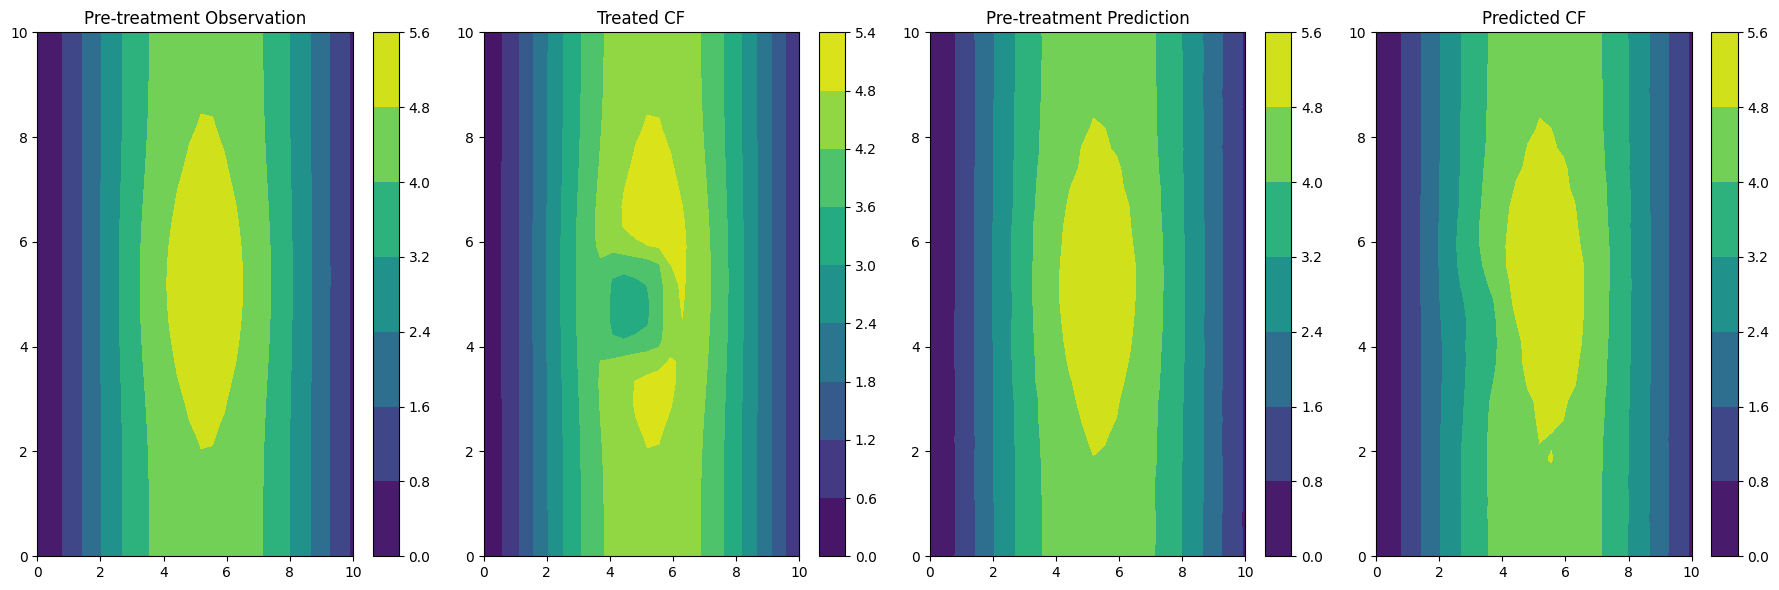

In [ ]:
# Plotting the final state of the variables
# Parameters
Lx = 10.0      # Length of the domain in the x direction
Ly = 10.0      # Length of the domain in the y direction
Nx = 28        # Number of spatial points in the x direction
Ny = 28        # Number of spatial points in the y direction

# Spatial and temporal discretization
x = np.linspace(0, Lx, Nx)
y = np.linspace(0, Ly, Ny)
X, Y = np.meshgrid(x, y)

plt.figure(figsize=(18, 6))

plt.subplot(1, 4, 1)
plt.contourf(X, Y, inv_y_test[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Pre-treatment Observation')

plt.subplot(1, 4, 2)
plt.contourf(X, Y, cf_data[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Treated CF')

plt.subplot(1, 4, 3)
plt.contourf(X, Y, inv_y_pred[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Pre-treatment Prediction')

plt.subplot(1, 4, 4)
plt.contourf(X, Y, inv_y_pred_cf[1500, :, :], cmap='viridis')
plt.colorbar()
plt.title('Predicted CF')

plt.tight_layout()
plt.show()

In [ ]:
ts = inv_y_pred.shape[0]
time_series1 = np.array([np.mean(inv_y_pred_cf[i,:,:]) for i in range(ts)])
time_series2 = np.array([np.mean(cf_data[i,:,:]) for i in range(ts)])
print(time_series2.shape)

(4998,)


Text(0, 0.5, 'Outcome(Y)')

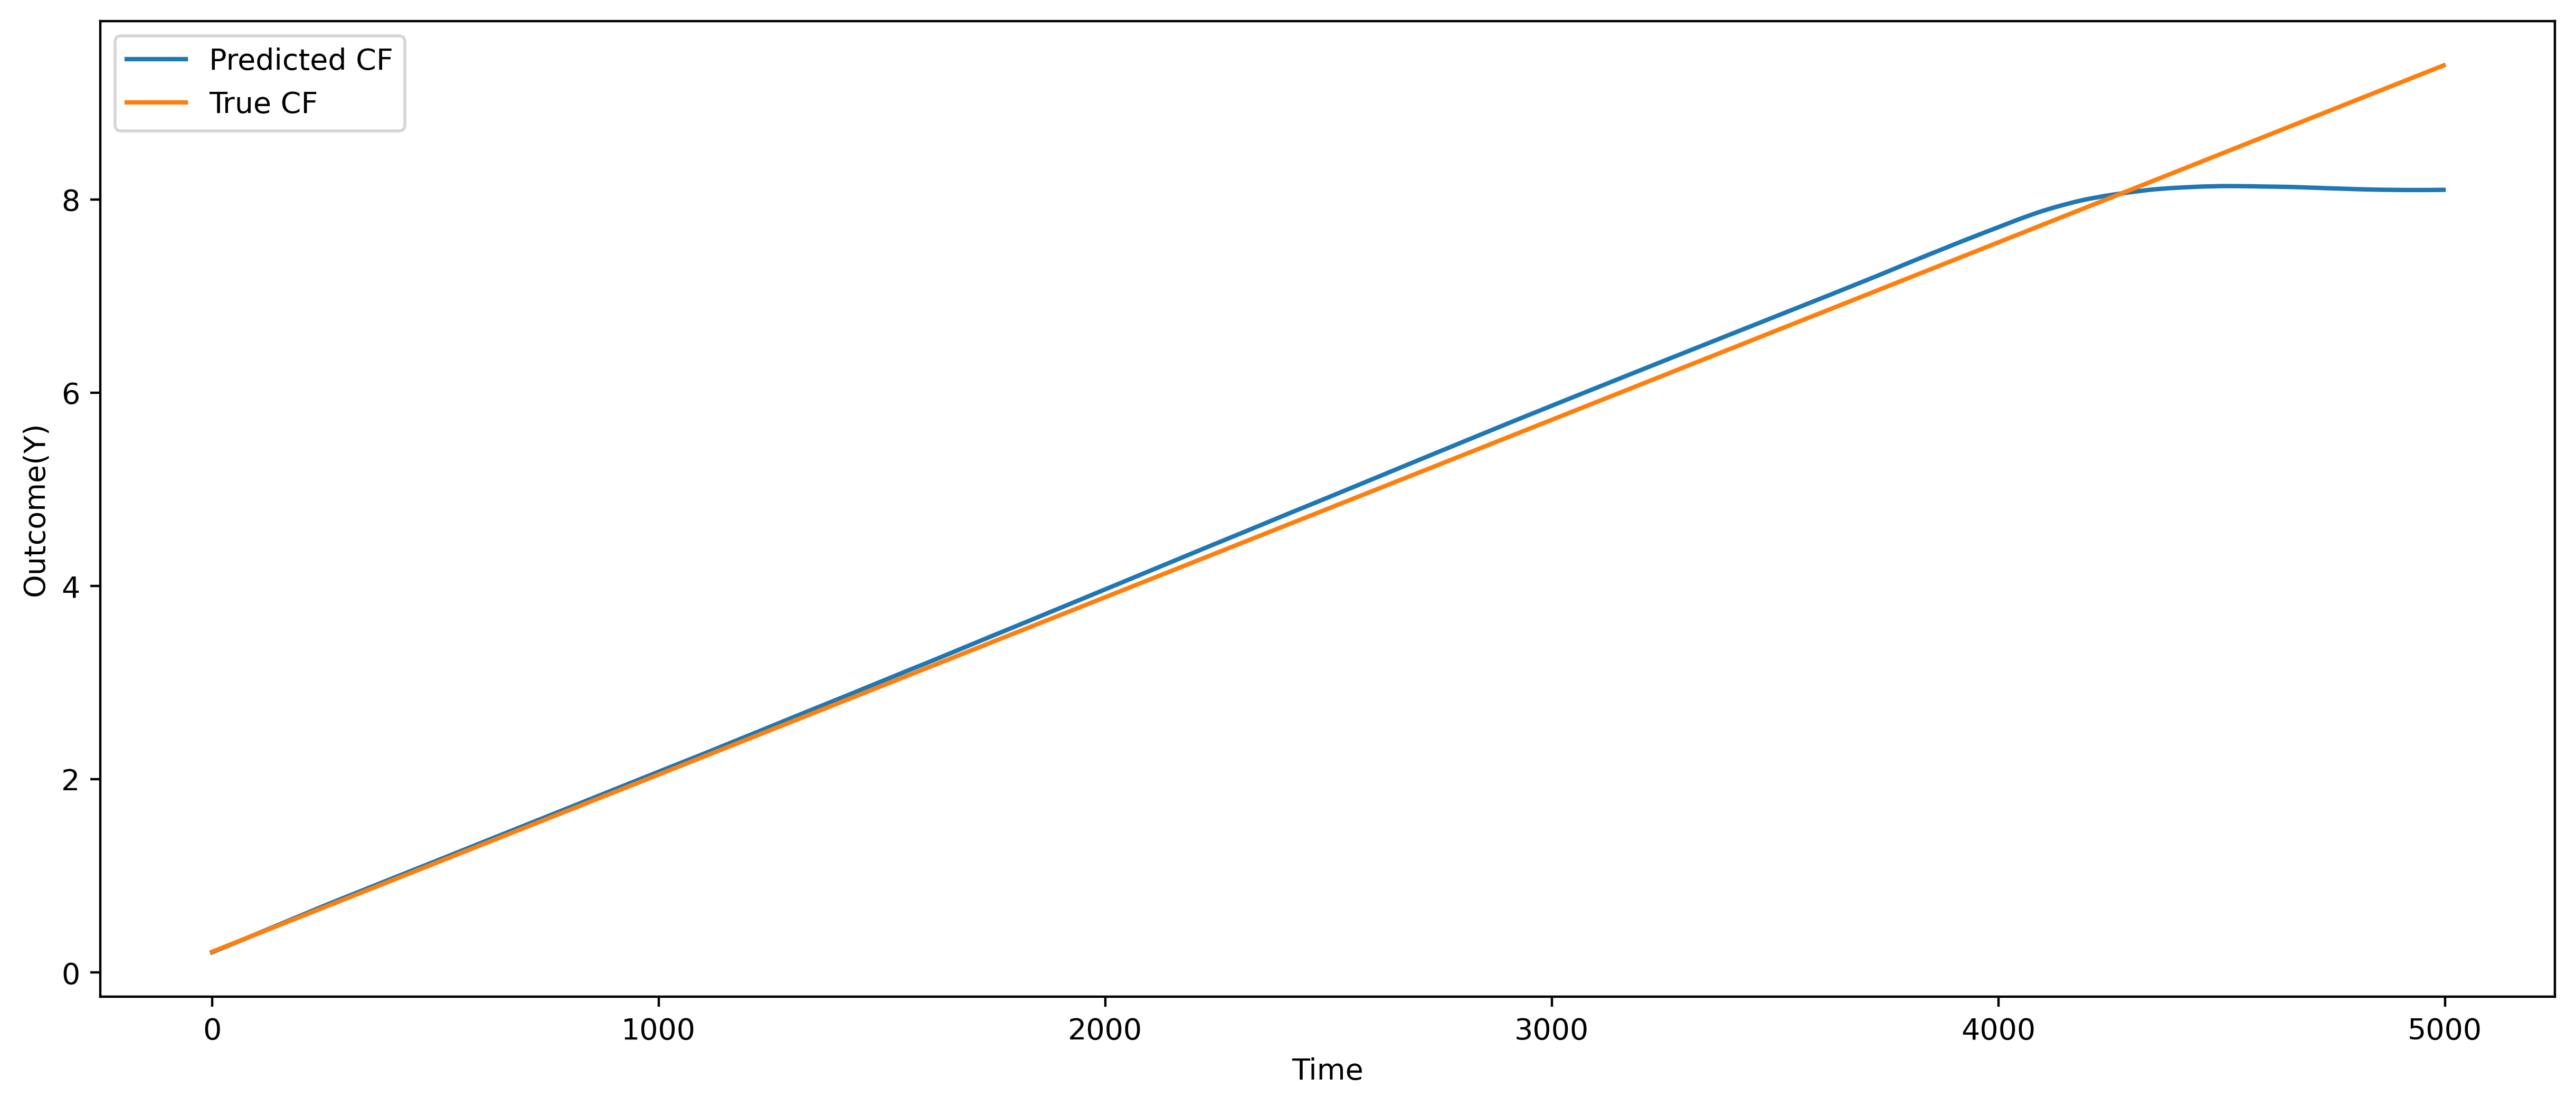

In [ ]:
fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),time_series1, label = "Predicted CF")
ax.plot(range(ts),time_series2, label = "True CF")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")

In [ ]:
ts = inv_y_pred.shape[0]
time_series3 = np.array([np.mean(inv_y_pred_cf[i,10:15,10:15]) for i in range(ts)])
time_series4 = np.array([np.mean(cf_data[i,10:15,10:15]) for i in range(ts)])
print(time_series2.shape)

(4998,)


In [ ]:
ts = inv_y_pred.shape[0]
time_series5 = np.array([np.mean(inv_y_test[i,:,:]) for i in range(ts)])
time_series6 = np.array([np.mean(cf_data[i,:,:]) for i in range(ts)])
print(time_series5.shape)

(4998,)


Text(0, 0.5, 'Outcome(Y)')

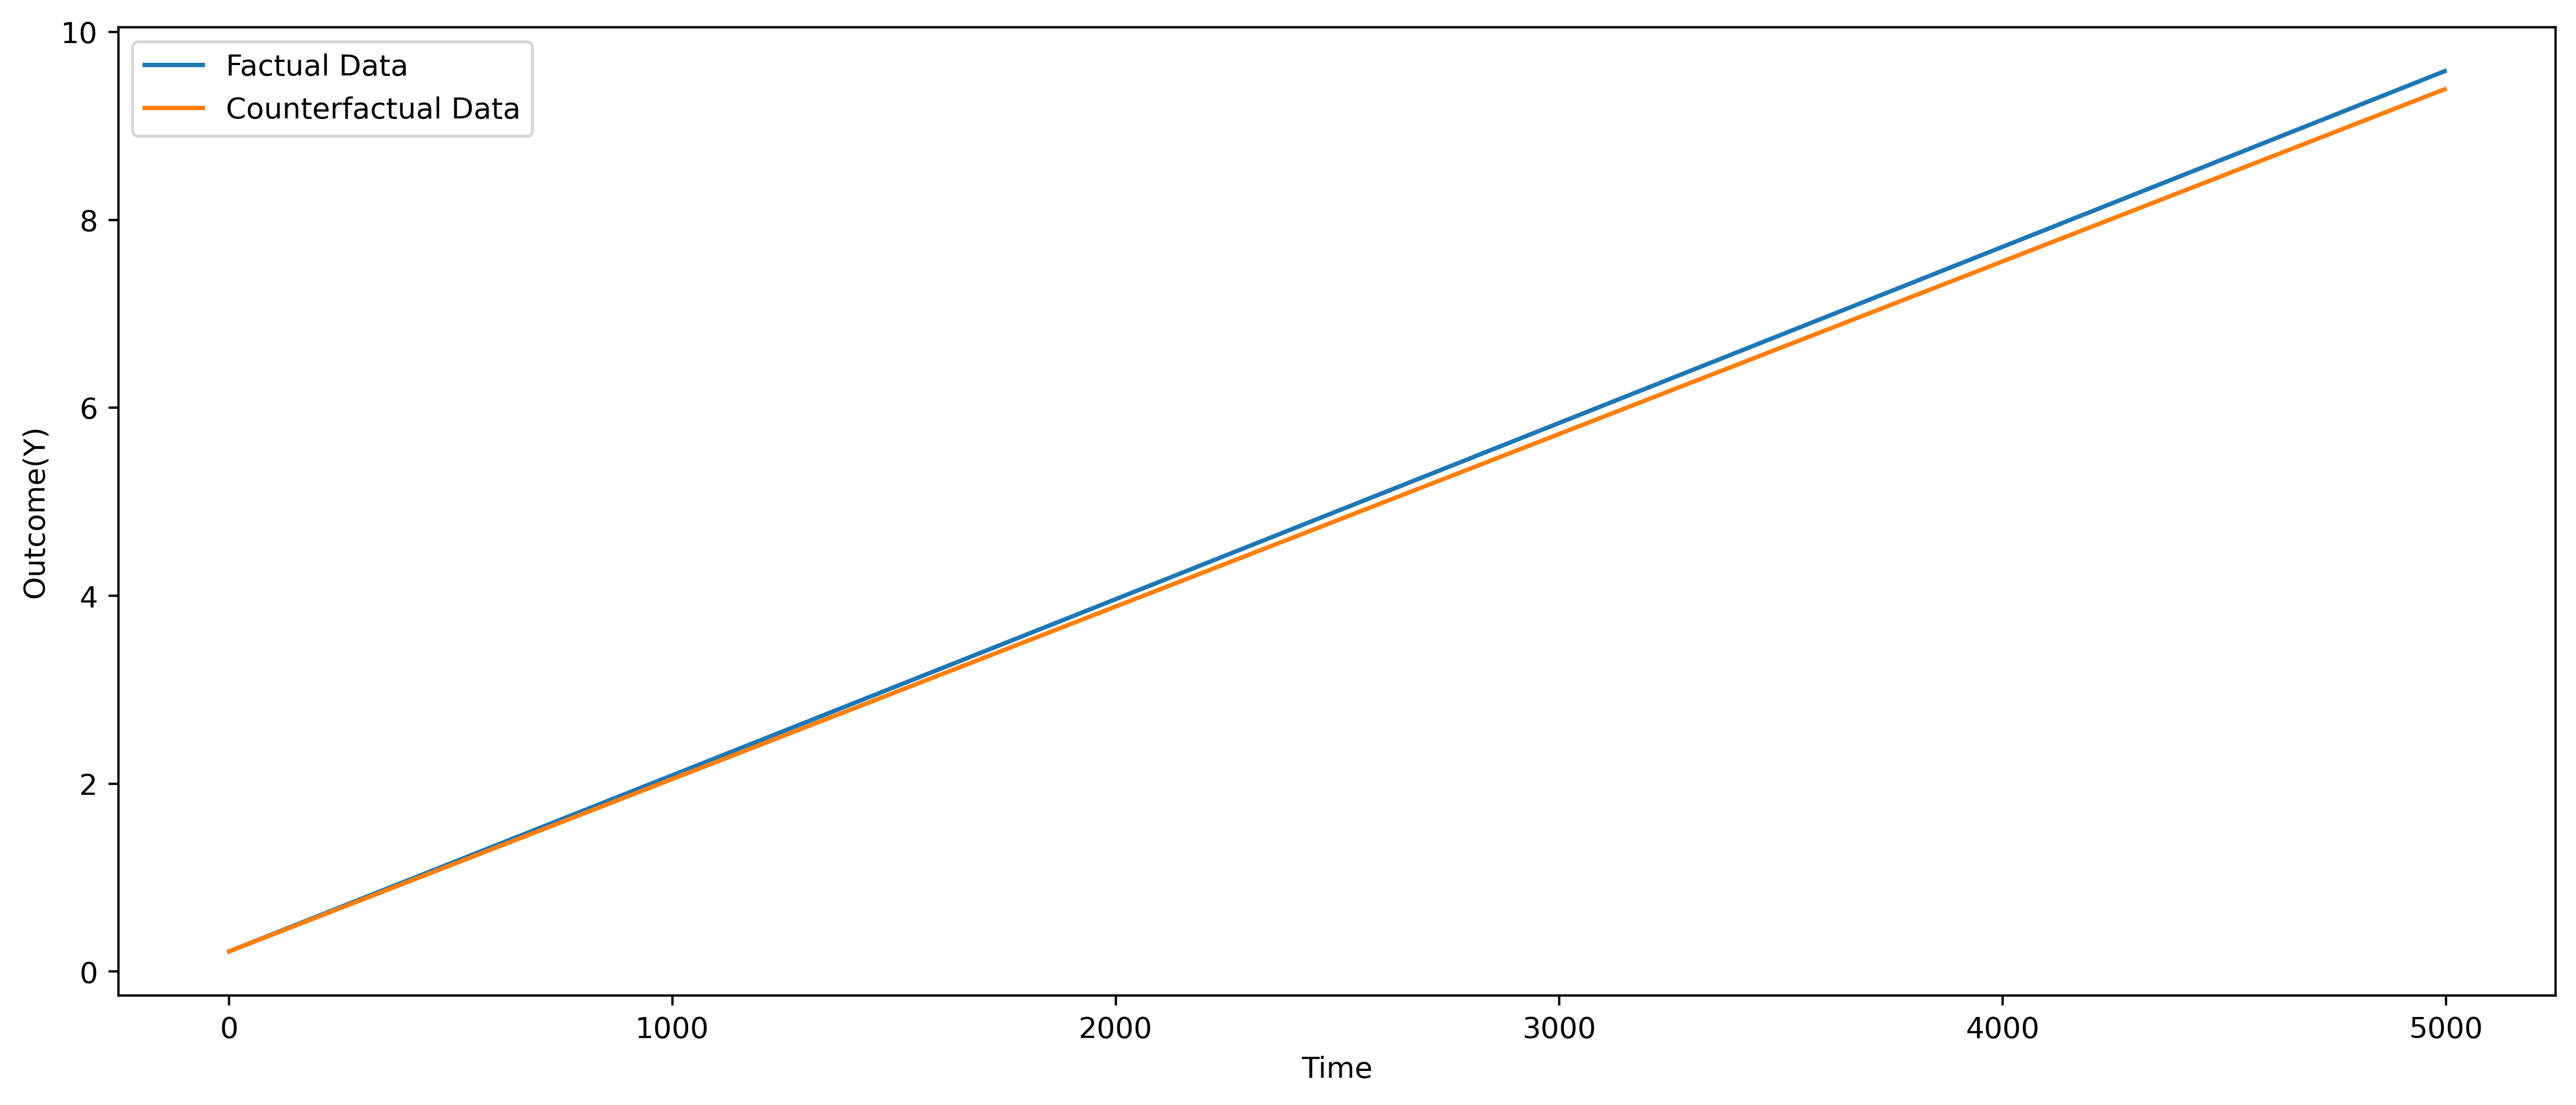

In [ ]:
fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),time_series5, label = "Factual Data")
ax.plot(range(ts),time_series6, label = "Counterfactual Data")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")

In [ ]:
ts = inv_y_pred.shape[0]
time_series7 = np.array([np.mean(inv_y_test[i,:,:]) for i in range(ts)])
time_series8 = np.array([np.mean(inv_y_pred[i,:,:]) for i in range(ts)])
print(time_series7.shape)

(4998,)


Text(0, 0.5, 'Outcome(Y)')

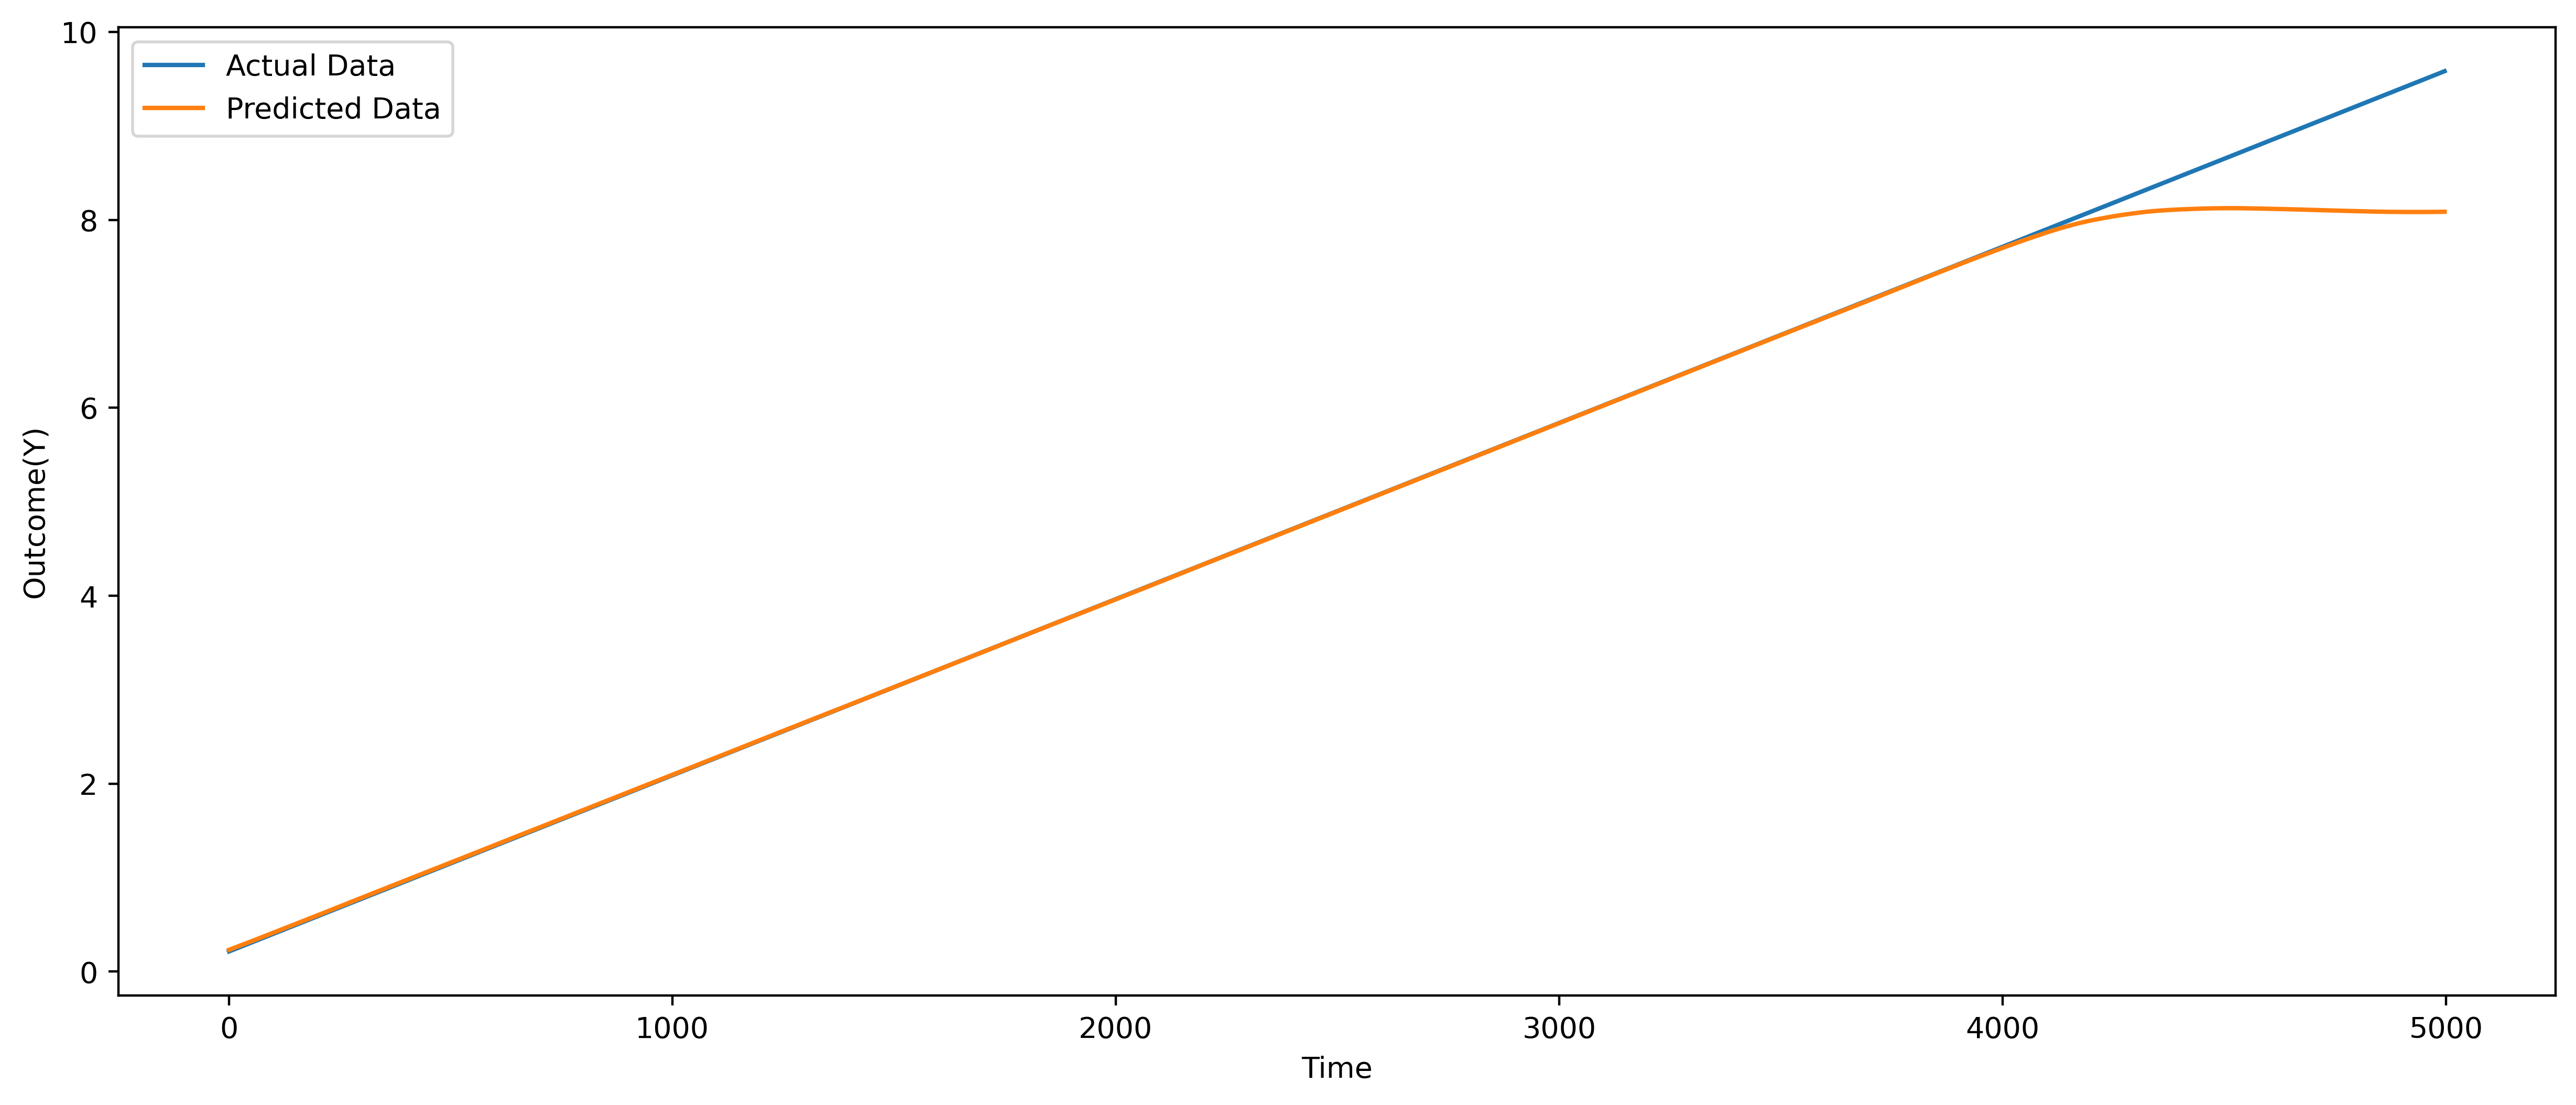

In [ ]:
fig,ax = plt.subplots(figsize = [15,6], dpi = 400)
ax.plot(range(ts),time_series7, label = "Actual Data")
ax.plot(range(ts),time_series8, label = "Predicted Data")
ax.legend()
ax.set_xlabel("Time")
ax.set_ylabel(r"Outcome(Y)")